# Introduction

The goal of this unit is to give you a wide inventory to critique experimental studies while expressing those critiques with computational models. The toolkit is pretty big now. We have tools to explore heterogeneity, sample size, and generalizability. Along the way, I've suggested that applying these tools might help us debunk bad studeies. Yet, we haven't actually seen this debunking happen yet! The Asch study, on closer review, turns out to be just fine (maybe some trouble with generalizability but hard to say).

The Bargh study, by contrast, is infamous for failing replication. And I've been posing the question: could we have known something was wrong back in 1996 or did we just have to wait until 2012 to find out there were issues? Today, we'll find two distinct problems that do raise serious questions about thre results. Measurement error and causal mediation. It will turn out that these are exactly the two sorts of errors [the replication study](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0029081&type=printable) suggests as motivations. If you want to see scientific debate in action, you might checkout that paper.

# How to represent measurement error

There are many sources of noise in an experiment. Some of them are fairly benign: the fact that some people are taller in the control group, or late for class, or sleepy. All introduce variation that we have a way of modeling with normal distributions. These sources of variation are also measured - we know how far off from the group mean each person is.

But other sources of noise aren't so nice: measurement error is one. Measurement error is a unique problem because it is unmeasured variation. All we have is the recorded speeds. We do not know how far off they are. So there might be further sources of noise then we have access to. Let's explore how to model this.

In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

url = 'https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/bargh_experiment_2_data'

data = pd.read_csv(url)

control = data[data.group == 1]
primed = data[data.group == 0]
control_speed = control.speeds.values
primed_speed = primed.speeds.values

First, we'll plot all the walking speeds on the y-axis and just evenly space the participants on the x-axis.

Text(0, 0.5, 'walking speed')

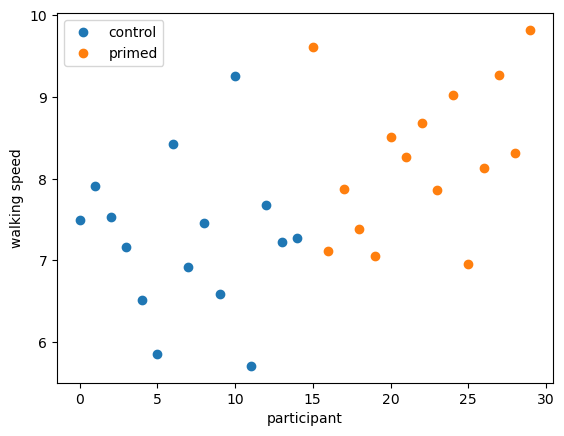

In [5]:
x = np.arange(30)

plt.plot(x[:15],control_speed,'o',label="control")
plt.plot(x[15:],primed_speed,'o',label="primed")
plt.xlabel("participant")
plt.legend()
plt.ylabel("walking speed")

We can represent the measurement error using normal distributions. Here's the thought. The stopwatch guy will make mistakes. Sometimes he goes high. Sometimes he goes low. But mostly we should think his guess are concentrated around the true walking speed. This is an awful lot like our football field metaphor from last class. There is a baseline (being correct) and then random factors making the stopwatch man go up or down. Naturally, it's not a perfect story. The stopwatch man could be consistently low. But that's just like moving the baseline down a bit. We already know that changing the starting location doesn't change the distribution.

This widget lets you visualize the data points under conditions of uncertainty. We do not quite know where they are so we add random normally distributed noise to each observed measurement. Then we sample 20 partial points from our normal distribution and plot them all with high transparency.

In [8]:
import ipywidgets as widgets

def draw_measurement_error(std):
    
    scatter = 20
    
    x1 = np.repeat(np.arange(15),scatter)
    y1 = stats.norm(np.repeat(control_speed,scatter),std).rvs()
    x2 = np.repeat(np.arange(15,30),scatter)
    y2 = stats.norm(np.repeat(primed_speed,scatter),std).rvs()

    plt.plot(x1,y1,'o',alpha=0.2,color="tab:blue")
    plt.plot(x2,y2,'o',alpha=0.2,color="tab:orange")
    plt.xlabel("participant")
    plt.ylabel("walking speed")

widgets.interact(draw_measurement_error,
                 std=widgets.FloatSlider(min=0.001, max=1.5, step=0.01, value=0.001))

interactive(children=(FloatSlider(value=0.001, description='std', max=1.5, min=0.001, step=0.01), Output()), _…

<function __main__.draw_measurement_error(std)>

As you play with this, notice when the two groups are no longer easily distinguishable. At that point, that's enough measurement error to make learning the difference between the groups impossible.

## Realistic bounds on measurement error

Playing with the slider is great. But what is a plausible value to set our measurement error parameter to? In class a few days ago, I had everyone time me as I moved across the front the classroom. Here is the distribution of your answers.

0.4891946633857744

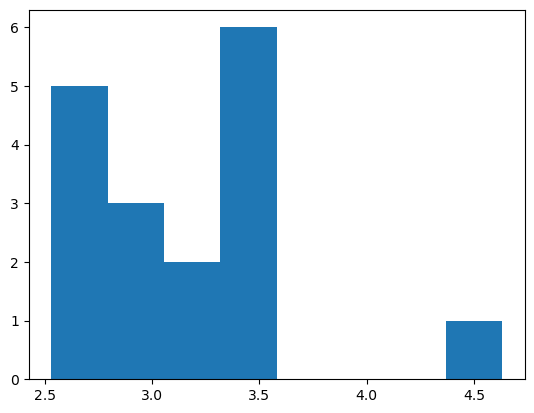

In [9]:
speeds = [2.79,3.18,2.93,2.89,3.39,3.35,3.45,3.43,3.49,2.69,3.13,2.68,4.63,3.01,3.53,2.53,2.63]
plt.hist(speeds,bins=8)
np.std(speeds)

In this case, we still don't know what my "true" score was. But it does give an indication of how much wiggle room there is when humans are trying to measure something with a stop watch. A standard deviation of about 0.5 seems plausible.

## P-value sensitivity testing

We can now deploy our new tool to explore how sensitive the p-value is to measurement error. The strategy works like this: we don't really know where the data points are but we have a good way to guess. We'll use the observed walking speeds as our best guess and then add a normal distribution with standard deviation 0.5 around them.

In [6]:
# this code pushes the whole array of control speeds through the `stats.norm()` object
# so it's using 15 different means to generate samples.

stats.norm(control_speed,0.5).rvs()

array([7.14786378, 8.68753109, 7.01931043, 7.48803241, 7.50856187,
       5.47853246, 9.0505225 , 7.69500672, 7.11091735, 7.57009876,
       9.04998548, 6.2540824 , 7.70820591, 7.07905588, 7.86966385])

This can give us datasets that wiggle a little bit in ways we think are consistent with our measurement device. Then we'll repeatedly draw wiggly samples and conduct t-tests on them. If we do this 1000 (or 2000 or whatever) times, we'll get a distribution of possible p-values. If our p-values spread out a lot, that tells us our experiment is highly sensitive to measurement error.

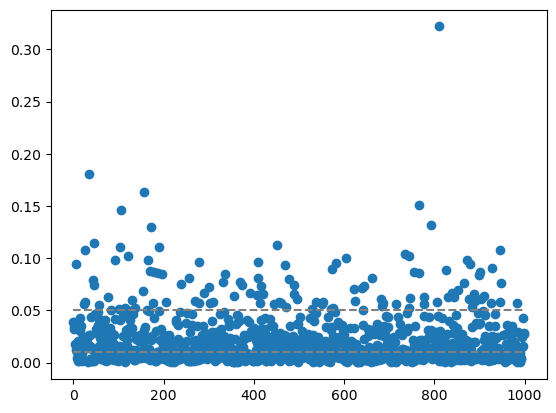

In [10]:
pvalues = []

for i in range(1000):
    
    g1 = stats.norm(control_speed,0.5).rvs()
    g2 = stats.norm(primed_speed,0.5).rvs()
    ttest = stats.ttest_ind(g1,g2)
    pvalues.append(ttest.pvalue)
    
plt.plot(pvalues,'o')
plt.plot(range(1000),[0.05]*1000,'--',color='grey')
plt.plot(range(1000),[0.01]*1000,'--',color='grey')

I've plotted the 0.01 and 0.05 significance thresholds to help you visually sort the outcomes. It looks like our p-value can move a fair amount in response to modeling the measurement error.

We can also count how many observations are above each significance threshold.

In [11]:
acc = 0
for val in pvalues:
    if val > 0.01:
        acc = acc + 1
        
acc / 1000

0.613

About 61% of hypothetical p-values are no longer significant at the 0.01 level.

In [12]:
acc = 0
for val in pvalues:
    if val > 0.05:
        acc = acc + 1
        
acc / 1000

0.116

And 11% of the p-values are no longer significant at the 0.05 level. 

This makes good intuitive sense. The evidence is less certain once we incorporate the uncertainty from measurement errors. It is harder to firmly reject the null hypothesis. Or more broadly, it's plausible that the two groups do not really have different baseline walking speeds. They just appear to have different speeds because of a combination of random variation and bad luck on the part of the stopwatch man.

Like much of what we do, whether this argument is a defeat for Bargh and friends depends on whether we are making fair and plausible assumptions. Our thought about how much measurement error stopwatchers go make is also just an estimate. So we could rerun the model with a smaller standard deviation. Alternatively, assuming normally distributed noise isn't the only option. There might be heterogeneity in the stopwatching too. We could use Student's T distribution to model the noise.

# Mediation and causal pathways

For Bargh and colleagues, they do not just want to know *whether* or not behavioral priming can effect walking speed. They also want to know the particular causal mechanism by *which* the effect takes place. The whole introduction to paper is an argument for the theoretical plausibility that our minds reproduce automatically and without conscious awareness of environmental cue. So if the effect of behavioral priming travelled through some other route, that wouldn't help their case very much.

Other researchers think it is very plausible the causal effect does travel through another route - experimenters' expectations. If an experimenter thinks you should walk slower leaving the room, they can subtly cue you to walk slower. Maybe they guide you from the table to the door at a slow pace, setting a pace that you follow down the hallway. Maybe they speak in a slow and calm voice to only the primed group to relax them. In the 2012 follow-up study, they have this to say about the potential for experimenter induced bias.

![https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Bargh_replication.png](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Bargh_replication.png)

We can represent this sort of argument with a model also. The big takeaway is that the causal effect Bargh and colleagues are after are *non-identifiable* - which means the experiment they ran cannot identify the causal effect they are after. Let's see what some models look like.

## Studying causal pathways in simulation

Our first step is just to create some simulated people and randomly assign them to the primed group or control group.

In [9]:
primed = np.random.randint(low=0,high=2,size=30)
primed

array([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0])

Now we'll create three "causal pathways", little simulated worlds where we control what causes what. In the first pathway, what I'll call the direct path, there is no problem. The world works the way Bargh wants. Walking speed is a direct function of whether or not you are primed.

$$y = 7.3 + 1 * x$$

This expression captures that. 7.3 is the time-in-hallway for the control group. x is a binary variable that represents whether you were primed or not. 1 is the size of the caual effect - if you were primed, it adds one second to your time in the hallway.

In [10]:
# direct path

# speed = control group speed + causal_coefficient * whether or not you were primed.
speed = 7.3 + 1 * primed
speed

array([8.3, 7.3, 7.3, 8.3, 7.3, 8.3, 7.3, 8.3, 7.3, 7.3, 7.3, 8.3, 8.3,
       7.3, 7.3, 7.3, 7.3, 8.3, 8.3, 8.3, 7.3, 8.3, 7.3, 8.3, 8.3, 8.3,
       8.3, 7.3, 7.3, 7.3])

Here is the path that the 2012 people are suggesting. If you are primed, then that also turns on experimenter's bias. The experimenter also adds one second to your walking speed. Priming itself does not directly add anything to your walking speed. We can represent this visually with what is called a "directed acyclic graph".

In [ ]:
# don't worry to much about the graphviz code. We'll revisit later in the term when you need to actually learn it.

from graphviz import Digraph

dot = Digraph()

dot.node("a",'Primed')
dot.node("b",'Walking_speed')
dot.node("c","experimenter")

dot.edges(['ac'])
dot.edges(['cb'])
dot

Or, represent it again with linear equations.

In [11]:
# indirect path

experimenter_bias = 1 * primed

speed = 7.3 + 1 * experimenter_bias + 0 * primed
speed

array([8.3, 7.3, 7.3, 8.3, 7.3, 8.3, 7.3, 8.3, 7.3, 7.3, 7.3, 8.3, 8.3,
       7.3, 7.3, 7.3, 7.3, 8.3, 8.3, 8.3, 7.3, 8.3, 7.3, 8.3, 8.3, 8.3,
       8.3, 7.3, 7.3, 7.3])

As you can see, that data is identical in this scenario as it is in the other scenario.

Finally, we might imagine a kind of compromise scenario. Both priming and experimenter bias have an effect. So we are assuming Bargh and friends are correct to some extent - behavioral priming is real. However, we cannot reliably identify how big the effect is. It is *non-identifiable*.

In [ ]:
dot = Digraph()

dot.node("a",'Primed')
dot.node("b",'Walking_speed')
dot.node("c","experimenter")

dot.edges(['ac'])
dot.edges(['ab'])
dot.edges(['cb'])
dot

In [13]:
# both pathes

speed = 7.3 + 0.5 * experimenter_bias + 0.5 * primed
speed

array([8.3, 7.3, 7.3, 8.3, 7.3, 8.3, 7.3, 8.3, 7.3, 7.3, 7.3, 8.3, 8.3,
       7.3, 7.3, 7.3, 7.3, 8.3, 8.3, 8.3, 7.3, 8.3, 7.3, 8.3, 8.3, 8.3,
       8.3, 7.3, 7.3, 7.3])

The above equation suggests speed is half caused by experimenter_bias and half caused by priming. So the resulting data is exactly the same. The situation for inference is even worse though. We cannot assume it's half and half. There are lots of ways we might weight the causal coefficients to produce exactly the same outcome. Here is one where experimenter bias makes people walk *faster* but behavioral priming cancels it out.

In [15]:
speed = 7.3 - 0.1 * experimenter_bias + 1.1 * primed
speed

array([8.3, 7.3, 7.3, 8.3, 7.3, 8.3, 7.3, 8.3, 7.3, 7.3, 7.3, 8.3, 8.3,
       7.3, 7.3, 7.3, 7.3, 8.3, 8.3, 8.3, 7.3, 8.3, 7.3, 8.3, 8.3, 8.3,
       8.3, 7.3, 7.3, 7.3])

Here is another where behavioral priming actually makes people faster but the experimenter_bias effect is so strong that it masks it.

In [16]:
speed = 7.3 + 2 * experimenter_bias - 1 * primed
speed

array([8.3, 7.3, 7.3, 8.3, 7.3, 8.3, 7.3, 8.3, 7.3, 7.3, 7.3, 8.3, 8.3,
       7.3, 7.3, 7.3, 7.3, 8.3, 8.3, 8.3, 7.3, 8.3, 7.3, 8.3, 8.3, 8.3,
       8.3, 7.3, 7.3, 7.3])

All produce the same exact data. So by looking at the data, it is impossible to tell the relative size of the causal effects.

## Mediation from mood and p-value fallacies

Bargh and colleagues are not unaware of potential problems from mediation. It is just that they explored potential mediation from a different source. Immediately after reporting and discussing the experiment 2a and 2b that we looked at, they run a short follow up study to explore the effect from mediation from mood. Here's there thought - thinking about the elderly might make people sad. And if they are sad, they walk slower. So, it's another possible causal pathway. The real trouble is - sadness is suppose to be a state we are aware of. If the goal is demonstrate the existence of automatic, subaware mental mechanisms, then having the priming effect travel through mood wouldn't get the job done.

More specifically, they are worried about a causal graph like this:

In [ ]:
dot = Digraph()

dot.node("a",'Primed')
dot.node("b",'Walking_speed')
dot.node("c","mood")

dot.edges(['ac'])
dot.edges(['ab'])
dot.edges(['cb'])
dot

To help them distinguish the causal pathways, they try to get a measurement of how much influence priming has on mood. They get 33 participants to go through the same word scramble task. Except this time, instead of measureing their walking speed, they make them take a series of mood questionaires that ask them questions on a [-8, 8] scale with 8 being happiest and -8 being unhappy. I'm going to show you what they say about their own results but the big spoiler is: none of this makes any goddamn sense. This is an example of many things you should not do when thinking through your own problems. We'll break down the logical fallacies slowly.


![](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/bargh_mood_results.png)

The first logical fallacy is the way they intepret statistical significance. Remember back in unit one, I made a big deal about how statistical significance testing can only help you identify what is false, it cannot help you identify what is true. They get the interpretation backwards here. 

A multivariate analysis of variance is just a special kind of t-test that's been generalized to handle more than one outcome variable. So in this case, they have the variable 'whether or not you are primed' to generate groups and then they perform multiple t-tests with mood and arousal. MANOVA has a couple of extra technical tricks but the core intuition is the same as the t-test. We assume there is really just one super group for the distribution of moods and the apparent differences between them only arise through random variation. Or more simply, priming has no effect on mood. That's the null hypothesis.

Now they fail to find statisticall significant evidence to reject this null hypothesis. So they infer that "participants who were exposed to the elderly stereotype stimuli were not more likely to be sad". This is where the fallacy shows up. This fallacy is super common across the sciences and can be very hard to spot so if you don't see it the first time, you are normal. The problem is that the logic of statistical significance is inherently confusing, your brain is doing okay.

But the core point is this - failure to reject a hypothesis doesn't mean it is true. If your t-test doesn't turn up a significant result, that doesn't imply anything in particular about the world. For example, suppose we assume Lady Bristol only has a 0.5 chance of getting a cup right or wrong. Now she gets 5 out of 8 cups correct. That evidence is not enough to reject our hypothesis. Does that mean her true accuracy is 0.5? Nope. Her true accuracy is very likely to be in the neighborhood 0f 0.55-0.7. After all, she did slightly between then 4/8, so we should put some credibility in the theory that she has a little bit of ability.

That's not what Bargh and colleagues do. Instead they infer the the causal pathway between priming and mood is closed. So nothing to worry about.

## Mediation from mood the right way

Could we do better? We have powerful Bayesian tools for estimating the true causal effect so we do not have to just rely on convoluted logic of statistical significance testing. Let's build up a different way of estimating the structure of the causal graph.

Here is what our data looks like.

In [2]:
url = 'https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/bargh_experiment_2_point_1_data'

data = pd.read_csv(url)

primed = data[data.primed == 1]
control = data[data.primed == 0]
primed

,primed,mood
0,1,4
1,1,2
2,1,2
3,1,-2
6,1,1
8,1,-1
9,1,7
11,1,-1
13,1,2
15,1,3


What kind of distribution should we use to model the outcome? Our outcome is discrete, the mood survey only goes in integers. So that suggests a binomial (or perhaps a beta-binomial. But let's start simple).

Immediately though we havea problem - negative numbers. Binomials only model positive integers and zero. It's like you can get 0 cups correct, but you cannot get -1 cups correct.

A nice solution is to just rescale our data so it ranges from [0,16].

In [33]:
mood_control = control.mood.values + 8
mood_primed = primed.mood.values + 8

Now we can estimate two proportions, each represent how happy the groups are out of the total possible amount of happiness.

In [34]:
with pm.Model() as mediation:
    p1 = pm.Beta('p_control',1,1)
    p2 = pm.Beta('p_primed',1,1)
    
    y1 = pm.Binomial('y_control',n=16,p=p1,observed = mood_control)
    y2 = pm.Binomial('y_primed',n=16,p=p2,observed = mood_primed)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_control, p_primed]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


The result shows us the primed group is a little bit happier than the control group. So that's a pretty different picture from what Bargh and colleagues told us. There is some causal influence of priming on mood, albeit, it might be small.

array([<AxesSubplot: title={'center': 'p_control'}>,
       <AxesSubplot: title={'center': 'p_primed'}>], dtype=object)

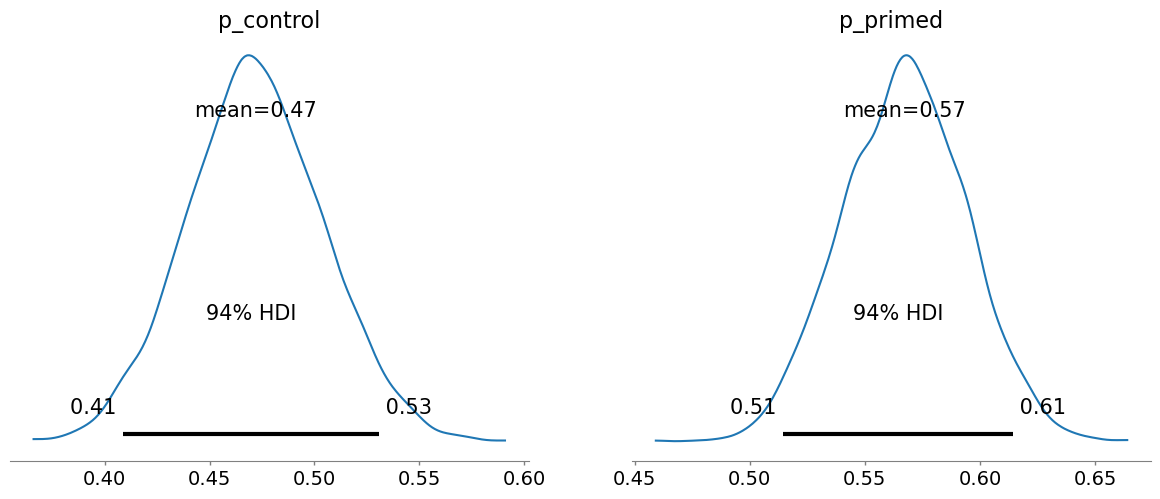

In [35]:
az.plot_posterior(trace)

There inference was that priming makes 0 difference to the mood. It is easy to see that this cannot be right. If you compare these two posteriors, very little credibility is allocated to the idea that priming makes zero difference. Priming clearly does make a little bit of difference.

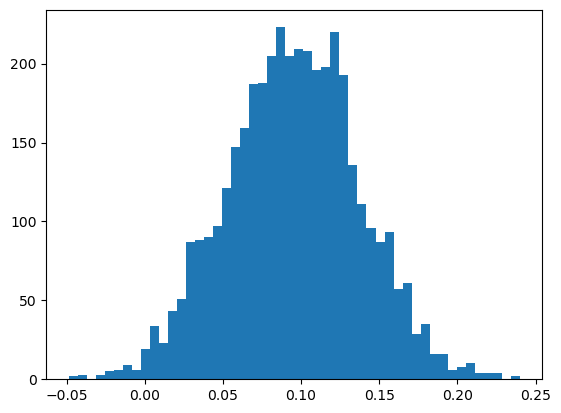

In [36]:
diffs = trace.posterior['p_primed'].values.flatten() - trace.posterior['p_control'].values.flatten()
plt.hist(diffs,bins=50);

Okay what can we conclude from all this? Well it's still an open question whether mood could mediate the results in a way that's damaging to their conclusions. The pathway from priming to mood is still open.

Bargh and colleagues have one final line of defense. If priming makes people happier, our little result is nothing to worry about. Their theory is that sadness makes you slower so only sadness provides a counter explanation for their results. If priming makes people happer and being happy makes you faster, then that just really implies the priming effect is even stronger than they thought. In other words, they thing the causal structure looks something like this:

In [23]:
primed = np.random.randint(low=0,high=2,size=30)

# small effect where priming improves the mood:

mood = 0.1 * primed

# and the being happy makes you faster but priming makes you extra slow

speed = 7.3 - 1 * mood + 1.1 * primed
speed

array([7.3, 7.3, 7.3, 8.3, 7.3, 7.3, 7.3, 7.3, 7.3, 7.3, 8.3, 7.3, 7.3,
       7.3, 8.3, 8.3, 7.3, 8.3, 8.3, 8.3, 8.3, 7.3, 8.3, 7.3, 8.3, 8.3,
       7.3, 8.3, 7.3, 8.3])

I think this potential argument from Bargh and colleagues is silly. It all depends on assuming that only sad moods make people slower. But they didn't have evidence for that claim. They just assumed it. I think other assumptions are also plausible - maybe happy people are more content and in less of a hurry to leave. What we really need is some way of estimating the causal effect of mood on walking speed, something Bargh's data doesn't let us do. The best version of the study would combine a measure of walking speed with a measure of moods. Then we would have everything we need to partition out the different causal pathways. We'll explore that topic in more depth next unit.